# Gradient Boosting From Scratch

Let's implement gradient boosting from scratch.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.datasets import boston_housing

np.random.seed(0)

plt.rcParams['figure.figsize'] = (8.0, 5.0)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14

In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [3]:
x_train.shape

(404, 13)

## Exploration

Let explore the data before building a model. The goal is to predict the median value of owner-occupied homes in $1000s.


In [4]:
# Create training/test dataframes for visualization/data exploration.
# Description of features: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']
df_train = pd.DataFrame(x_train, columns=feature_names)
df_test = pd.DataFrame(x_test, columns=feature_names)

Correlation analysis.

In [5]:
df_train['price'] = y_train
corr = df_train.corr()[['price']]
corr.style.background_gradient(cmap='coolwarm')

,price
CRIM,-0.378498
ZN,0.380299
INDUS,-0.476743
CHAS,0.168661
NOX,-0.438328
RM,0.681483
AGE,-0.364173
DIS,0.2539
RAD,-0.375515
TAX,-0.448737


It looks like `LSTAT` is negatively correlated with price. Let's plot it out:

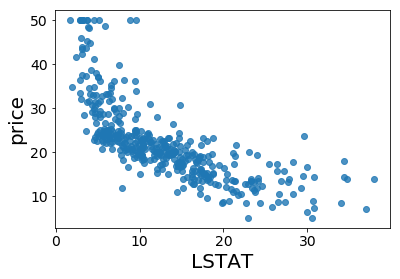

In [6]:
sns.regplot(x='LSTAT', y='price', data=df_train, fit_reg=False);

Most of the prices are less than 30:

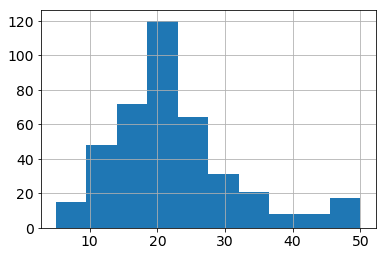

In [7]:
df_train.price.hist();

## Train Gradient Boosting model

Training Steps to build model an ensemble of $K$ estimators.
1. At $k=0$ build base model ,  $\hat{y}_{0}$: $\hat{y}_{0}=base\_predicted$
3. Compute residuals $r = \sum_{i=0}^n (y_{k,i} - \hat{y}_{k,i})$; $n: number\ train\ examples$
4. Train new model, fitting on residuals, $r$. We will call the predictions from this model $e_{k}\_predicted$
5. Update model predictions at step $k$ by adding residual to current predictions: $\hat{y}_{k} = \hat{y}_{k-1} + e_{k}\_predicted$
6. Repeat steps 2 - 5 `K` times.

In summary, the goal is to build K estimators that learn to predict the residuals from the prior model; thus we are learning to "correct" the
predictions up until this point.
<br>

$\hat{y}_{K} = base\_predicted\ +\ \sum_{j=1}^Ke_{j}\_predicted$

### Build base model

In [8]:
class BaseModel(object):
    """Initial model that predicts mean of train set."""

    def __init__(self, y):
        self.train_mean = y.mean()

    def predict(self, x):
        """Return train mean for every prediction."""
        return np.ones(x.shape[0]) * self.train_mean

def pred(x, model):
    result = model.predict(x)
    return result.squeeze()  # Remove unnecessary dimension from prediction.

def compute_residuals(label, pred):
    """Compute difference of labels and predictions.

    When using mean squared error loss function, the residual indicates the 
    negative gradient of the loss function in prediction space. Thus by fitting
    the residuals, we performing gradient descent in prediction space. See for
    more detail:

    https://explained.ai/gradient-boosting/L2-loss.html
    """
    return label - pred

def compute_rmse(x):
    return np.sqrt(np.mean(np.square(x)))

In [9]:
# Build a base model that predicts the mean of the training set.
base_model = BaseModel(y_train)
test_pred = base_model.predict(x_test)
test_residuals = compute_residuals(y_test, test_pred)
compute_rmse(test_residuals)

9.149363873885578

Let's see how the base model performs on out test data. Let's visualize performance compared to the `LSTAT` feature.

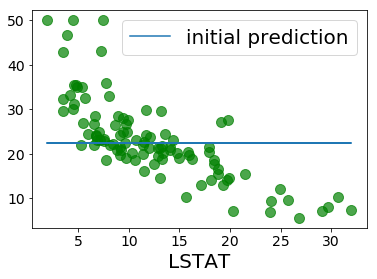

In [10]:
feature = df_test.LSTAT

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature, test_pred, label='initial prediction')

plt.xlabel('LSTAT', size=20)
plt.legend(prop={'size': 20});

There is definitely room for improvement. We can also look at the residuals:

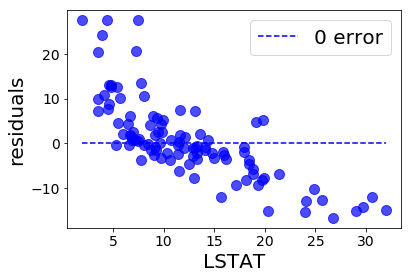

In [11]:
plt.plot(feature, test_residuals, 'bo', alpha=0.7, markersize=10)
plt.ylabel('residuals', size=20)
plt.xlabel('LSTAT', size=20)
plt.plot([feature.min(), feature.max()], [0, 0], 'b--', label='0 error');
plt.legend(prop={'size': 20});

### Train Boosting model

Returning back to boosting, let's use our very first base model as are initial prediction. We'll then perform subsequent boosting iterations to improve upon this model.

Let's use a decision tree as our weak learner.

In [12]:
def create_weak_model(**tree_params):
    """Initialize decision tree model."""
    model = DecisionTreeRegressor(**tree_params)
    return model

Make initial prediction.

In [13]:
base_model = BaseModel(y_train)

In [16]:
# Training parameters. 
tree_params = {
    'max_depth': 1,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 50
BOOSTING_LR = 0.1

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)

# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))
    # Train weak learner.
    model = create_weak_model(**tree_params)
    model.fit(x_train, train_residuals)
    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    grad_approx = model.predict(x_train)
    train_pred += (grad_approx * BOOSTING_LR)
    train_residuals = compute_residuals(y_train, train_pred)  
    
    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred)  

## Interpret results

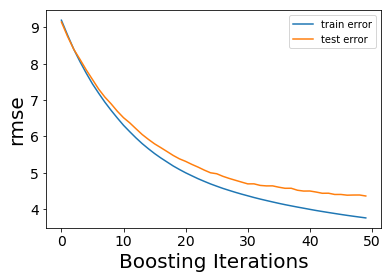

In [17]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=20)
plt.xlabel('Boosting Iterations', size=20);
plt.legend()

## Let's visualize how the performance changes across iterations

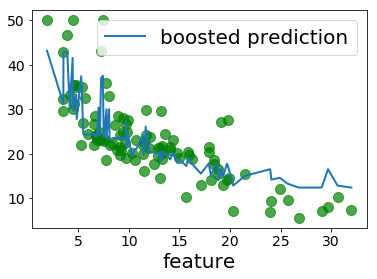

In [18]:
feature = df_test.LSTAT
ix = np.argsort(feature)

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('feature', size=20)
plt.legend(prop={'size': 20});

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License